In [2]:
#!pip install pytesseract
#!pip install wand
#!pip install pdf2image
#!pip install pypdf2
#!pip install pymongo

In [5]:
import sys
import cv2 as cv
import os
import pandas as pd
from tqdm import tqdm
import nltk

sys.path.append("..")
sys.path.append("../..")


from src.workflow.run import run_workflow, run_workflow_luigi

from src.notebooks.plot_utils import plot_extraction, plot_image
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from src.ingestion.input import stage_document
from src.ocr.process_ocr import process_pdf_image
from src.text_format.process_text import process_layout_text
from src.extraction.extract import extract
from src.notebooks.plot_utils import plot_extraction

from src.extraction.invoice_number import extract_invoice_number
from src.extraction.invoice_amount import extract_invoice_amount
from src.extraction.invoice_currency import extract_invoice_currency
from src.extraction.invoice_date import extract_invoice_date
from src.extraction.signature import extract_signature
from src.extraction.proper_nouns import extract_proper_nouns
from src.storage.storage_service import get_text_content
from src.storage.storage_service import get_image_file_path, get_num_pages, get_extraction_data
from src.extraction.utils import bbox_helper, bbox_merge

from src.extraction.classifier.create_raw_texts import create_raw_texts
from src.extraction.classifier.train_classifier import train_classifier
from src.extraction.classifier.text_utils import get_doc_texts
from src.storage.storage_service import search_file_projection


# 0. Train classifier

Classifier used to extract attribute "commercial invoice"

In [28]:
doc_path = "C:/Users/daluca/Workspace/data/input"
documents = os.listdir(doc_path)
for doc_name in tqdm(documents):
    doc_id = stage_document(doc_name)
    process_pdf_image(doc_id)
    process_layout_text(doc_id)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.11s/it]


In [29]:
create_raw_texts()

In [30]:
train_classifier()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2


Validation accuracy: 1.0


# 1. Run process step by step

In [25]:
# 1. ingest document
doc_name = "Invoice_28092018-171040.pdf"
doc_id = stage_document(doc_name)

In [26]:
# 2. process pdf image

process_pdf_image(doc_id)


'7b582b14c344424d97db67f67a6ef8cd'

In [27]:
# 3. process layout text

process_layout_text(doc_id)


'7b582b14c344424d97db67f67a6ef8cd'

In [31]:
# 4. extract information

extract(doc_id)

[0]
Exception MongoDB: E11000 duplicate key error collection: dluca.extract index: _id_ dup key: { _id: "/documents/7b582b14c344424d97db67f67a6ef8cd/extraction.json" }, full error: {'index': 0, 'code': 11000, 'keyPattern': {'_id': 1}, 'keyValue': {'_id': '/documents/7b582b14c344424d97db67f67a6ef8cd/extraction.json'}, 'errmsg': 'E11000 duplicate key error collection: dluca.extract index: _id_ dup key: { _id: "/documents/7b582b14c344424d97db67f67a6ef8cd/extraction.json" }'}


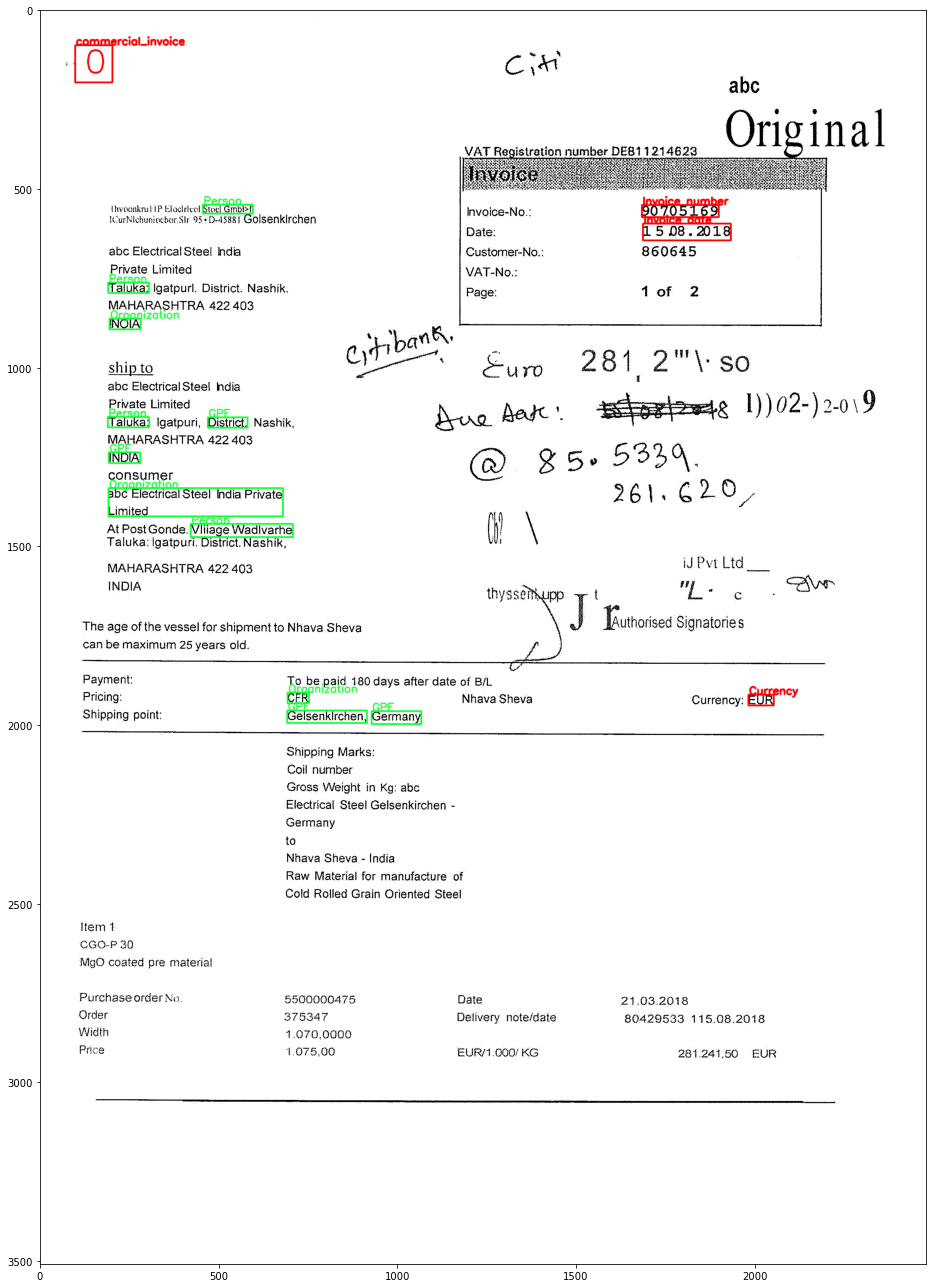

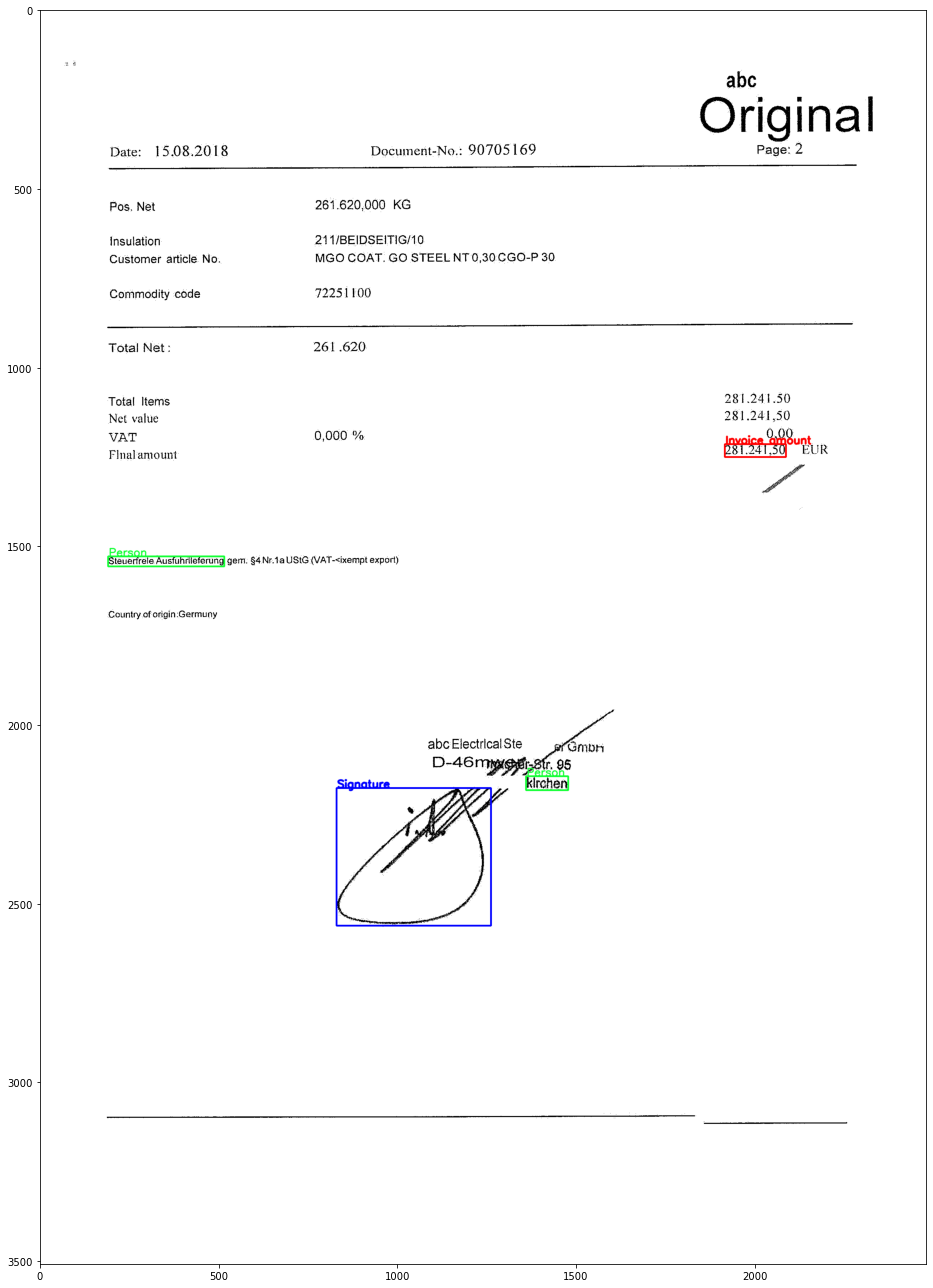

In [32]:
# 5. plot extracted information

plot_extraction(doc_id)

## 1.1. Extraction functions

In [36]:
# input data
input_data = get_text_content(doc_id,layout=True)

# invoice number
invoice_number = extract_invoice_number(input_data)
# invoice currency
invoice_currency = extract_invoice_currency(input_data)
# invoice amount
invoice_amount = extract_invoice_amount(input_data)
# invoice date
invoice_date = extract_invoice_date(input_data)
# signature
signature = extract_signature(doc_id)
# name entity recognition: proper nouns
proper_nouns = extract_proper_nouns(input_data)
print(invoice_currency, "\n\n", invoice_number, "\n\n", invoice_amount, "\n\n", invoice_date, "\n\n", signature, "\n\n", proper_nouns)

{'invoice_currency': {'extraction': {'value': 'EUR', 'normalized_value': 'EUR', 'value_words': [{'id': 'word_133', 'line': 'line_45', 'x1': 1983, 'y1': 1917, 'x2': 2050, 'y2': 1943, 't': 'EUR', 'marked': True}], 'page_number': '0'}}} 

 {'invoice_number': {'extraction': {'value': '90705169   ', 'normalized_value': '90705169', 'value_words': [{'id': 'word_18', 'line': 'line_9', 'x1': 1685, 'y1': 547, 'x2': 1896, 'y2': 577, 't': '90705169', 'marked': True}], 'page_number': '0'}}} 

 {'invoice_amount': {'extraction': {'value': '281.241,50', 'normalized_value': '281.241,50', 'value_words': [{'id': 'word_45', 'line': 'line_14', 'x1': 1917, 'y1': 1216, 'x2': 2084, 'y2': 1248, 't': '281.241,50', 'marked': True}], 'page_number': '1'}}} 

 {'invoice_date': {'extraction': {'value': '15 08.2018     ', 'normalized_value': '2018-08-15T00:00:00', 'value_words': [{'id': 'word_25', 'line': 'line_11', 'x1': 1688, 'y1': 604, 'x2': 1743, 'y2': 633, 't': '15', 'marked': True}, {'id': 'word_26', 'line': 'l

# 2. Run entire workflow

In [40]:
run_workflow("Invoice_28092018-171040.pdf")

[0]


TypeError: string indices must be integers

# 3. Run workflow - with luigi

In [38]:
os.chdir("../workflow")
!python -m luigi --module run Extract --local-scheduler

In C:\Users\daluca\Anaconda3\envs\endava_workshop\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\daluca\Anaconda3\envs\endava_workshop\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\daluca\Anaconda3\envs\endava_workshop\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\daluca\Anaconda3\envs\endava_workshop\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C